In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns 
import pandas as pd 
import numpy as np
import requests
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon, LineString 
from shapely.ops import nearest_points
from functools import partial
import geopandas as gpd
import pyproj
from shapely.ops import transform
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.sparse import lil_matrix
import itertools
from shapely import geometry, ops
import warnings
from itertools import combinations
import random
from random import choice, randint
import folium
import progressbar
import timeit
import time
from joblib import Parallel, delayed
import pickle
import math
warnings.simplefilter('ignore')

C:\Users\alexa\anaconda3\envs\ox\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
#Load in required data from data preparation
df=pd.read_pickle('Data/flows.csv')
G=nx.read_gpickle('Data/B10000-CS2.gpickle')
with open('Data/lengths.pickle', 'rb') as handle:
    lengths_dict = pickle.load(handle)
CS = pd.read_csv("Data/AllCurrentCS.csv", encoding="Cp1252")
CS = CS.drop('Unnamed: 0', axis=1)
G_dict={}
for i in G.edges:
    key_t=tuple(G.edges[i]['id'])
    key_f=tuple(reversed(G.edges[i]['id']))
    len_t=G.edges[i]['eff_len_t']
    len_f=G.edges[i]['eff_len_f']
    
    G_dict[key_t]=len_t
    G_dict[key_f]=len_f

paths=df['path'].to_dict()
flows=tuple(df['flow'])

In [3]:
def GravityModel(master_df):
    flow=[]
    master_df['flow']=0
    for i in master_df.index:
        GC=(0.75*(master_df['length'][i])+0.5*master_df['drivetime'][i])
        flow.append(master_df['weight'][i]/GC)
    
    tot_flow=sum(flow)
    for i in master_df.index:
        master_df['flow'][i]=flow[i]/tot_flow

In [4]:
def Objectivefunction(FacilitiesList, paths, flows, lengths_dict, G_dict, Totalrange):
    startime = time.time()
    CoveredObjectiveValue = 0
    facilities = tuple(FacilitiesList)
    
    for j in range(len(paths)):
        path = tuple(paths[j])
        NodeInFacilityListExistInPath = False
        if (lengths_dict[path[0],path[-1]]+lengths_dict[path[-1],path[0]]) <=Totalrange/2: # If the round trip length is shorter than half the EV range, add the flow immediately 
            CoveredObjectiveValue += flows[j]
        
        else:
            for node in path:
                if node in facilities:
                    NodeInFacilityListExistInPath = True
                    break
                    
                    
        if NodeInFacilityListExistInPath == True: #Only evaluate if at least one facility is on the path
            
            # Take first from Origin to Destination:
            if path[0] in facilities:
                rem_range = Totalrange
            else:
                rem_range = Totalrange/2
                
            indicator_canRefuel=0
                
            #Start looping through the path going first from origin to the destination:
            revpath = path[::-1][1:]
            fullpath = path+revpath                    
            
            for i in range(len(fullpath)+1):                
                a = fullpath[i]
                b = fullpath[i+1]                                                                                     
                rem_range -= G_dict[(a,b)]

                if rem_range <0:
                    break
                elif b == path[-1] & path[-1] in facilities:
                    indicator_canRefuel+=1
                    break
                elif b == path[0]:
                    indicator_canRefuel+=1
                    break
                elif b in facilities:
                    rem_range = Totalrange
            
            if indicator_canRefuel==1:
                
                
                # Now consider from Destination to Origin:
                dest_orig_path = path[::-1]
                fullpath = dest_orig_path + path[1:]

                if fullpath[0] in facilities:
                    rem_range = Totalrange
                else:
                    rem_range = Totalrange/2

                for i in range(len(fullpath)+1):            
                    a = fullpath[i]
                    b = fullpath[i+1]                                                                                     
                    rem_range -= G_dict[(a,b)]

                    if rem_range <0:
                        break
                    elif b == dest_orig_path[-1] & dest_orig_path[-1] in facilities:
                        indicator_canRefuel+=1
                        break
                    elif b == dest_orig_path[0]:
                        indicator_canRefuel+=1
                        break
                    elif b in facilities:
                        rem_range = Totalrange               

                if indicator_canRefuel==2:
                    CoveredObjectiveValue += flows[j]
    
                
    # endtime = time.time()
    # finaltime = endtime-startime
    # print('B2: '+str(finaltime))
    return CoveredObjectiveValue

In [5]:
def greedysub(p, k, Totalrange, sub_iterations, flows, paths, lengths_dict, G_dict):
    
    """
    Original implementation of Greedysub. Setting sub_iterations=0 effectively makes it a greedy-adding without substitution.
    """
    
    
    starttime = time.time()
    selectedFacilities = []
    for z in range(p):
        print(z)
        CurrentMaxObjectiveValue = 0
        CurrentMaxFacility = 0
        for facility in k:
            FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList.append(facility)
                TempObjectiveValue = Objectivefunction(FacilitiesList, paths, flows, lengths_dict, G_dict, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    CurrentMaxFacility = facility
        selectedFacilities.append(CurrentMaxFacility)
        
        for i in range(sub_iterations):
            SubFacilityIndex = list(np.setdiff1d(k,selectedFacilities))
            SubMaxObjectiveValue = 0
            SubMaxFacility = 0
            IndexBeingSubstituted = 0
            for index in range(len(selectedFacilities)):
                if selectedFacilities[index] != CurrentMaxFacility:
                    TempFacilities = selectedFacilities.copy()
                    TempFacilities.remove(selectedFacilities[index])
                    for Subfacility in SubFacilityIndex:
                        SubArray = TempFacilities.copy()
                        SubArray.append(Subfacility)
                        CurrentObjectiveValue = Objectivefunction(SubArray, paths, flows, lengths_dict, G_dict, Totalrange)
                        if CurrentObjectiveValue > SubMaxObjectiveValue:
                            SubMaxObjectiveValue = CurrentObjectiveValue
                            SubMaxFacility = Subfacility
                            IndexBeingSubstituted = index                        
            
            if SubMaxObjectiveValue > CurrentMaxObjectiveValue: 
                selectedFacilities[IndexBeingSubstituted] = SubMaxFacility
                CurrentMaxObjectiveValue = SubMaxObjectiveValue
                CurrentMaxFacility = SubMaxFacility
            else:
                break
            
    endtime = time.time()
    print("runtime",round(endtime-starttime,1),"seconds")
    return selectedFacilities, CurrentMaxObjectiveValue

In [6]:
def greedysub_b(p, k, Totalrange, sub_iterations, flows, paths, lengths_dict, G_dict, selfacs):
    """Slightly modified. New input variable selfacsa which is a set of facilities which are starting facilities"""
    
    if selfacs == []:
        # print("selfacs empty")
        selectedFacilities = []
    else:
        selectedFacilities = selfacs
        # print(selectedFacilities)
        
    starttime = time.time()
    for z in range(len(selfacs), p):
        print(z)
        CurrentMaxObjectiveValue = 0
        CurrentMaxFacility = 0
        for facility in k:
            FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList.append(facility)
                TempObjectiveValue = Objectivefunction_b2(FacilitiesList, paths, flows, lengths_dict, G_dict, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    CurrentMaxFacility = facility
        selectedFacilities.append(CurrentMaxFacility)        
        print(selectedFacilities)
        print(CurrentMaxObjectiveValue)
    endtime = time.time()
    final = endtime-starttime
    print("runtime",round(endtime-starttime,1),"seconds")
    return selectedFacilities, CurrentMaxObjectiveValue, final

In [7]:
#Find best solution for greedy-adding
def greedysub_mod(k, Totalrange, flows, paths, lengths_dict, G_dict, Threshold, selfacs):
    """
    Modified to loop until a Threshold objective function is met. If no facility can improve function it breaks and return best values
    """
    starttime = time.time()
    selectedFacilities = selfacs
    print(selectedFacilities)
    CurrentMaxObjectiveValue = 0
    quitloop = False
    dummy = 0
    while CurrentMaxObjectiveValue < Threshold and quitloop==False:
        print(CurrentMaxObjectiveValue)

        CurrentMaxFacility = 0
        for facility in k:
            FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList.append(facility)
                TempObjectiveValue = Objectivefunction_b2(FacilitiesList, paths, flows, lengths_dict, G_dict, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    CurrentMaxFacility = facility

        # if selectedFacilities[-1]==0:
        #     quitloop = True
        if CurrentMaxObjectiveValue > dummy:
            selectedFacilities.append(CurrentMaxFacility)
            print(selectedFacilities)
            dummy = CurrentMaxObjectiveValue
        elif CurrentMaxObjectiveValue == dummy:
            quitloop = True
        # print(pvals)
        # print(allflows)
    endtime = time.time()
    final = endtime-starttime
    print("runtime",round(endtime-starttime,1),"seconds")
    return selectedFacilities, CurrentMaxObjectiveValue, final


In [ ]:
#testing greedy.
p = 50
k=list(G.nodes)
sub_iterations = 0
Totalrange = 170000

# greedysub(p, k, df, Totalrange, sub_iterations, G)
greedysub(p, k, Totalrange, sub_iterations, flows, paths, lengths_dict, G_dict)

In [ ]:
#testing greedy sub, not possible due to runtime.
p = 50
k=list(G.nodes)
sub_iterations = 1
Totalrange = 170000

# greedysub(p, k, df, Totalrange, sub_iterations, G)
greedysub(p, k, Totalrange, sub_iterations, flows, paths, lengths_dict, G_dict)

In [8]:
def random_combination(k, p, pop_limit):
    pool = [i for i in k]
    population = []
    rest_filled=False
    while len(population) < pop_limit:
        if len(pool)>=p:
            chromosome_i = random.sample(pool, p)
            population.append(chromosome_i)
            for ind in chromosome_i:
                pool.remove(ind)            
        elif rest_filled==False:            
            fill_rest=random.sample(k,p-len(pool))
            population.append(pool+fill_rest)
            rest_filled=True
        else:
            chromosome_i = sorted(random.sample(k, p))            
            if chromosome_i not in population:
                population.append(chromosome_i)
    return population

def Union(father, mother):
    unionlist= list(set(father) | set(mother))
    return unionlist

In [9]:
def crossover(f, union, flows, paths, lengths_dict, G_dict):
    """
    Performs the greedy deletion crossover algorithm which is a part of the genetic algorithm
    
    input:
    f: iterator, f goes from 0 to length of union
    union: unioned chromosones from father and mother
    """
    
    A = union[f]
    totalgenes = len(A)
    for i in range(totalgenes, p, -1):
        CurrentMaxObjectiveValue = 0
        CurrentMaxIndex = 0
        for j in range(len(A)):
            TempFacilities = A.copy()
            TempFacilities.pop(j)                    
            TempObjectiveValue = Objectivefunction(TempFacilities, paths, flows, lengths_dict, G_dict, Totalrange)
            if TempObjectiveValue > CurrentMaxObjectiveValue:
                CurrentMaxObjectiveValue = TempObjectiveValue
                CurrentMaxIndex = j
        A.pop(CurrentMaxIndex)
    children1 = A
    return children1

In [10]:
def genetic(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict):
    
    """
    Genetic Algorithm. Algorithm that is modeled after the process of evolution. Starts with multiple sets of chromosones (random solutions) forming a population. Each chromosone consists of p genes (facilities). 
    For each generation, better solutions are produced until the maximum number of generations are reached of if the algorithm converges.
    
    Input:
    k: List of candidate locations
    p: Number of facilities to be located
    pop_limit: Starting population/population limit
    mutation_freq: Chance of gene mutation
    nr_gen: Number of generations
    Totalrange: Full range of the electric vehicles when fully recharged
    
    
    USED FOR CALIBRATION PURPOSES
    """
    #Initialize the maximum objective value and a list of all maximum objective values for each generation. Also initiate timer so we can measure the time spent
    MaxObjectiveValue = 0
    AllObjectiveValues = []
    start = time.time()
    
    #Initialize an empty list where the facilities that captures the most flow are stored
    best_pop = []
    
    #Initialize population
    population = random_combination(k, p, pop_limit)
    
    #Selecting the parents
    for x in range(nr_gen):
        mother = random.sample(population, round(pop_limit/2))
        for i in mother: 
            population.remove(i)
            
        father = population.copy()   

        #Union chromosones of mother and father
        iterations = len(father)
        union = [] 
        for i in range(iterations):
            temp = Union(father[i], mother[i])
            union.append(temp)
        #Greedy deletion crossover algorithm for each cromosone. Calls the crossover function and utilizes all available cores. This causes the algorithm to run about 200% faster
        start1=time.time()
        if __name__ == '__main__':
            children = Parallel(n_jobs=-1)(delayed(crossover)(f, union, flows, paths, lengths_dict, G_dict) for f in range(len(union)))
    
        end1=time.time()
        #New member selection. Select the two best out of children, mother and father, each with a length of pop_limit/2. Population length should then be = pop_limit
        population = []
        objectivevalues = []
        for i in range(round(pop_limit/2)):
            MotherValue = Objectivefunction(mother[i], paths, flows, lengths_dict, G_dict, Totalrange)
            FatherValue = Objectivefunction(father[i], paths, flows, lengths_dict, G_dict, Totalrange)
            ChildrenValue = Objectivefunction(children[i], paths, flows, lengths_dict, G_dict, Totalrange)
            minValue = min(MotherValue, FatherValue, ChildrenValue)
            maxValue = max(MotherValue, FatherValue, ChildrenValue)
            if MotherValue == minValue:
                population.append(list(father[i])) 
                population.append(list(children[i]))
                objectivevalues.append(FatherValue)
                objectivevalues.append(ChildrenValue)
            elif FatherValue == minValue:
                population.append(list(mother[i]))
                population.append(list(children[i]))
                objectivevalues.append(MotherValue)
                objectivevalues.append(ChildrenValue)            
            elif ChildrenValue == minValue:
                population.append(list(mother[i]))
                population.append(list(father[i]))
                objectivevalues.append(FatherValue)
                objectivevalues.append(MotherValue)
            
            #Picks the highest scoring chromosone and stores it as the best solution for current generation
            if MotherValue == maxValue:
                if MotherValue > MaxObjectiveValue:
                    MaxObjectiveValue = MotherValue
                    best_pop = mother[i]

            elif FatherValue == maxValue:
                if FatherValue > MaxObjectiveValue:
                    MaxObjectiveValue = FatherValue
                    best_pop = father[i]

            elif ChildrenValue == maxValue:               
                if ChildrenValue > MaxObjectiveValue:
                    MaxObjectiveValue = ChildrenValue
                    best_pop = children[i]                
        #Mutation, do not mutate last iteration
        if x < (nr_gen-1):
            for i in range(len(population)): #For each Chromosome
                if random.random() < mutation_freq: #If a chrosome is chosen one random gene in it will mutate 
                    j = randint(0, p-1)
                    population[i][j] = random.sample(k,1)[0]


        AllObjectiveValues.append(MaxObjectiveValue)

        """If best_pop flow has not improved the last three generations it is safe to assume that it has converged and the loop can break"""
        if len(AllObjectiveValues) > 4:
            if AllObjectiveValues[x] == AllObjectiveValues[(x-1)] == AllObjectiveValues[x-2] == AllObjectiveValues[x-3]:
                print("Convergence reached at gen:",(x+1))
                print(round(MaxObjectiveValue,2),"% of flow captured")
                end = time.time()
                print("runtime",round(end-start,1),"seconds")
                
                return MaxObjectiveValue, (x+1), (round(end-start,1))
            
    """If no convergence has occured, the algorithm will finish once it has completed all generations and return the best solution it could find"""
    # print("Maximum number of generations reached")
    # print("Flow captured:", MaxObjectiveValue)
    end = time.time()
    print("runtime",round(end-start,1),"seconds")
    final = end-start
    conv_gen = AllObjectiveValues.index(MaxObjectiveValue)+1
    #does not return best population. used for calibration
    return MaxObjectiveValue, final, conv_gen



In [11]:
def genetic_pop(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict, solution_co, indicat):
    """
    Genetic Algorithm. Algorithm that is modeled after the process of evolution. Starts with multiple sets of chromosones (random solutions) forming a population. Each chromosone consists of p genes (facilities). 
    For each generation, better solutions are produced until the maximum number of generations are reached of if the algorithm converges.
    
    Input:
    k: List of candidate locations
    p: Number of facilities to be located
    pop_limit: Starting population/population limit
    mutation_freq: Chance of gene mutation
    nr_gen: Number of generations
    Totalrange: Full range of the electric vehicles when fully recharged
    
    
    USED FOR FINDING BEST SOLUTIONS
    """
#Initialize the maximum objective value and a list of all maximum objective values for each generation. Also initiate timer so we can measure the time spent
    MaxObjectiveValue = 0
    AllObjectiveValues = []
    count_escape = 0
    start = time.time()
    
    #Initialize an empty list where the facilities that captures the most flow are stored
    best_pop = []
    
    #Initialize population
    if p*pop_limit<len(k):        
        init_pop_size=math.ceil(math.ceil((1583)/p)/2)*2
        population = random_combination(k, p, init_pop_size)
    else:
        population = random_combination(k, p, pop_limit)
        
    #inlcude solution_co in initial population:
    if indicat==1:
        population.append(solution_co)                
    
    #Selecting the parents
    for x in range(nr_gen):
        start_i=time.time()
        mother = random.sample(population, math.ceil(len(population)/2))
        for i in mother: 
            population.remove(i)        
        father = population.copy()        
        if len(mother)-len(father)==1:
            father.append(random_combination(k, p, 1)[0])
        
        #Union chromosones of mother and father
        union = [] 
        for i in range(len(father)):
            temp = Union(father[i], mother[i])
            union.append(temp)
        #Greedy deletion crossover algorithm for each cromosone. Calls the crossover function and utilizes all available cores. This causes the algorithm to run about 200% faster        
        if __name__ == '__main__':
            children = Parallel(n_jobs=-1)(delayed(crossover)(f, union, flows, paths, lengths_dict, G_dict) for f in range(len(union)))
    
        
        #New member selection. Select the two best out of children, mother and father, each with a length of pop_limit/2. Population length should then be = pop_limit
        population = []
        objectivevalues = []
        for i in range(len(father)):
            MotherValue = Objectivefunction(mother[i], paths, flows, lengths_dict, G_dict, Totalrange)
            FatherValue = Objectivefunction(father[i], paths, flows, lengths_dict, G_dict, Totalrange)
            ChildrenValue = Objectivefunction(children[i], paths, flows, lengths_dict, G_dict, Totalrange)
            minValue = min(MotherValue, FatherValue, ChildrenValue)
            maxValue = max(MotherValue, FatherValue, ChildrenValue)
            if MotherValue == minValue:
                population.append(list(father[i])) 
                population.append(list(children[i]))
                objectivevalues.append(FatherValue)
                objectivevalues.append(ChildrenValue)
            elif FatherValue == minValue:
                population.append(list(mother[i]))
                population.append(list(children[i]))
                objectivevalues.append(MotherValue)
                objectivevalues.append(ChildrenValue)            
            elif ChildrenValue == minValue:
                population.append(list(mother[i]))
                population.append(list(father[i]))
                objectivevalues.append(FatherValue)
                objectivevalues.append(MotherValue)
            
            #Picks the highest scoring chromosone and stores it as the best solution for current generation
            if MotherValue == maxValue:
                if MotherValue > MaxObjectiveValue:
                    MaxObjectiveValue = MotherValue
                    best_pop = mother[i]

            elif FatherValue == maxValue:
                if FatherValue > MaxObjectiveValue:
                    MaxObjectiveValue = FatherValue
                    best_pop = father[i]

            elif ChildrenValue == maxValue:               
                if ChildrenValue > MaxObjectiveValue:
                    MaxObjectiveValue = ChildrenValue
                    best_pop = children[i]
        
        # Keep the best chromosomes to uphold the pop limit
        if len(population)>(pop_limit+1):                                  
            ob_values=[]           
            for i in range(len(population)):
                ob_values.append(Objectivefunction(population[i], paths, flows, lengths_dict, G_dict, Totalrange))
            fram=pd.DataFrame(ob_values)
            limit=pop_limit+(round((init_pop_size-pop_limit)/2))
            if x==0:
                keep=fram.sort_values(0, ascending=False)[0:limit]
            if x==1:
                keep=fram.sort_values(0, ascending=False)[0:pop_limit]
            indexes=list(keep.index)
            population=[population[i] for i in indexes]
            
        #Mutation, do not mutate last iteration
        if x < (nr_gen-1):            
            for i in range(len(population)): #For each Chromosome
                if random.random() < mutation_freq: #If a chrosome is chosen one random gene in it will mutate 
                    j = randint(0, p-1)
                    sub_in=random.sample(k,1)[0]
                    if sub_in not in population[i]:
                        population[i][j] = random.sample(k,1)[0]
                    else:
                        population[i][j] = random.sample(k,1)[0]
            
            # for i in range(len(population)): #For each Chromosome
            #     for j in range(p):
            #         if random.random() < mutation_freq: #If a gene is chosen one random gene in it will mutate                         
            #             sub_in=random.sample(k,1)[0]
            #             if sub_in not in population[i]:
            #                 population[i][j] = random.sample(k,1)[0]
            #             else:
            #                 population[i][j] = random.sample(k,1)[0]


        end_i=time.time()
        print("Generation:", (x+1), 'Flow:', MaxObjectiveValue, round(end_i-start_i,1))
        print(best_pop)
        AllObjectiveValues.append(MaxObjectiveValue)

        """If best_pop flow has not improved the last three generations it is safe to assume that it has converged and the loop can break"""        
        if len(AllObjectiveValues) > 5:
            if AllObjectiveValues[x] == AllObjectiveValues[(x-1)] == AllObjectiveValues[x-2]== AllObjectiveValues[x-3]:                                          
        
                for i in range(len(AllObjectiveValues)):
                    if AllObjectiveValues[i]==MaxObjectiveValue:
                        first_max_found=i+1
                        break
                end = time.time()                
                print(round(end-start,1), 'sek')
                # return MaxObjectiveValue, round(end-start,1), first_max_found
        
        
                return MaxObjectiveValue, best_pop, (round(end-start,1))
                
                
                
        # print("Generation:", (x+1), "Flow:", MaxObjectiveValue, count_escape)
            
    """If no convergence has occured, the algorithm will finish once it has completed all generations and return the best solution it could find"""
    # print("Maximum number of generations reached")
    # print("Flow captured:", MaxObjectiveValue)
    
    end = time.time()
    print(round(end-start,1), 'sek')
    for i in range(len(AllObjectiveValues)):
        if AllObjectiveValues[i]==MaxObjectiveValue:
            first_max_found=i+1
            break
    # return MaxObjectiveValue, round(end-start,1), first_max_found
    ######## mutation calibration: #######
   
    return MaxObjectiveValue, best_pop, (round(end-start,1))

In [ ]:
"""
Calibration of GA pop_limit
"""
startime=time.time()
ptest = [10,15,20,25,30]
popu = [50,100,200]

numberofiter = 3

populations = []
limits = []
flowCaptured = []
runtimes = []
conv_gen = []
for g in popu:
    
    
    for v in (ptest):
        tempObjective = 0
        runtime = 0
        convergence = 0
        populations.append(v)
        limits.append(g)
        for l in range(numberofiter):
            k = list(G.nodes)
            p = v
            pop_limit = g
            mutation_freq = 0.05
            nr_gen = 15
            Totalrange = 300000
            MaxObj, tempruntime, conv =  geneticv3(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict)
            if MaxObj > tempObjective:
                tempObjective = MaxObj
                runtime = tempruntime
                convergence = conv
        flowCaptured.append(tempObjective)
        runtimes.append(runtime)
        conv_gen.append(convergence)
endtime = time.time()
print(endtime-startime)
d = {'p':populations,'population_size':limits, 'flow_covered':flowCaptured, 'runtime':runtimes, 'convergence gen':convergence}
df2=pd.DataFrame(d)
df2.sort_values(by=['p','population_size'])

In [ ]:
p = 100
k=tuple(G.nodes)
pop_limit = 2
mutation_freq = 0.05
Totalrange = 170000
nr_gen = 15

genetic_pop(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict, solution_co=sol_co, indicat=1)

In [ ]:
#Check how many CS the greedy suggests to get current and max flow captured for each range
k=list(G.nodes)
thresholdvalues = [1,1,1]
ranges = [170000,325000,585000]
results_greedy = pd.DataFrame(columns = ['Vehicle Range','Minimum percent to be covered', 'number of facilities','flow captured','runtime','facilities'])


for i in range(6):
    setLocations = []
    selectedfacilities, currentflow, runtime = greedysub_mod(k, ranges[i], flows, paths, lengths_dict, G_dict, setLocations, thresholdvalues[i])
    pfacs = (len(selectedfacilities))
    if currentflow > 0.99999: #Rounds flow captured to 1 if it is bigger than 0.999
        currentflow=1
    temp = ranges[i], thresholdvalues[i], pfacs, currentflow, runtime, selectedfacilities
    seriestoappend = pd.Series(temp, index=results_greedy.columns)
    results_greedy = results_greedy.append(seriestoappend, ignore_index=True) 
        
#Apparently python will not add the facilities correctly, will do this manually then.
actualvals = []
for i in results_greedy.index:
    end = results_greedy.iloc[i]['number of facilities']
    temp = results_greedy.iloc[i]['facilities']
    actual = temp[:end]
    actual = [i for i in actual if i != 0]
    actualvals.append(actual)
results_greedy['facilities']=actualvals

In [ ]:
#Plot greedy max flows
#Data for plotting p vs flow for greedy algo
def greedysub_mod2(k, Totalrange, flows, paths, lengths_dict, G_dict, Threshold):
    
    starttime = time.time()
    selectedFacilities = []
    CurrentMaxObjectiveValue = 0
    quitloop = False
    pvals = 0
    numberofp = []
    allflows = []
    while CurrentMaxObjectiveValue < Threshold and quitloop==False:
        # print(CurrentMaxObjectiveValue)
        # CurrentMaxObjectiveValue = 0
        CurrentMaxFacility = 0
        for facility in k:
            FacilitiesList = selectedFacilities.copy()
            if facility not in selectedFacilities:
                FacilitiesList.append(facility)
                TempObjectiveValue = Objectivefunction_b2(FacilitiesList, paths, flows, lengths_dict, G_dict, Totalrange)
                if (TempObjectiveValue > CurrentMaxObjectiveValue):
                    CurrentMaxObjectiveValue = TempObjectiveValue
                    if CurrentMaxObjectiveValue > 0.999999999:
                        CurrentMaxObjectiveValue = 1
                    CurrentMaxFacility = facility
        try:
            if selectedFacilities[-1]==0:
                quitloop = True
        except IndexError:
            pass
        selectedFacilities.append(CurrentMaxFacility)
        pvals +=1
        numberofp.append(pvals)
        allflows.append(CurrentMaxObjectiveValue)
        # print(pvals)
        # print(allflows)
    endtime = time.time()
    final = endtime-starttime
    print("runtime",round(endtime-starttime,1),"seconds")
    return numberofp, allflows


xval170, yval170 = greedysub_mod2(k, 170000, flows, paths, lengths_dict, G_dict, 0.99999)
xval325, yval325 = greedysub_mod2(k, 325000, flows, paths, lengths_dict, G_dict, 0.99999)
xval585, yval585 = greedysub_mod2(k, 585000, flows, paths, lengths_dict, G_dict, 0.99999)

In [ ]:
lenxval = len(xval170)
lenyval325 = len(yval325)
lenyval585 = len(yval585)
y325t = yval325.copy()
y585t = yval585.copy()

In [ ]:
#Add last value to 325 and 585 and make it same length as 170

for i in range(100):
    y325t.append(yval325[-1])
    y585t.append(yval585[-1])

y325 = y325t[:lenxval]
y585 = y585t[:lenxval]

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(xval170, yval170, label="170km range")
plt.plot(xval170,y325, label="325km range")
plt.plot(xval170,y585, label="585km range")
plt.xlabel("Number of Charging Stations", fontsize=20)
plt.ylabel("Flow Captured", fontsize=20)
plt.margins(x=0)
plt.legend(frameon = False, fontsize=15)
plt.tick_params(labelright=True)
plt.yticks([0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1], fontsize=15)
xticks = [i for i in range(5,95,5)]
xticks.append(1)
xticks.sort()
plt.xticks(xticks, fontsize=15)
# plt.hlines(y=0.684, xmin=21, xmax=89, color="black", linestyle="dotted")
# plt.hlines(y=0.925, xmin=32, xmax=89, color="black", linestyle="dotted")
# plt.hlines(y=0.998, xmin=0, xmax=29, color="black", linestyle="dotted")
# plt.vlines(x=21, ymin=0.3, ymax=0.684, color="black", linestyle="dotted")

plt.savefig("Data/Figures/FlowCapturedGreedy.png", dpi=400,bbox_inches='tight')

In [ ]:
p = 55
pop_limit = round(math.ceil(1583/p)/2)
mutation_freq = 0.05
nr_gen = 25
k = tuple(G.nodes)
Totalrange = 170000

flow_best170, best_pop170, runtime170=genetic_pop(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict, solution_co, indicat)

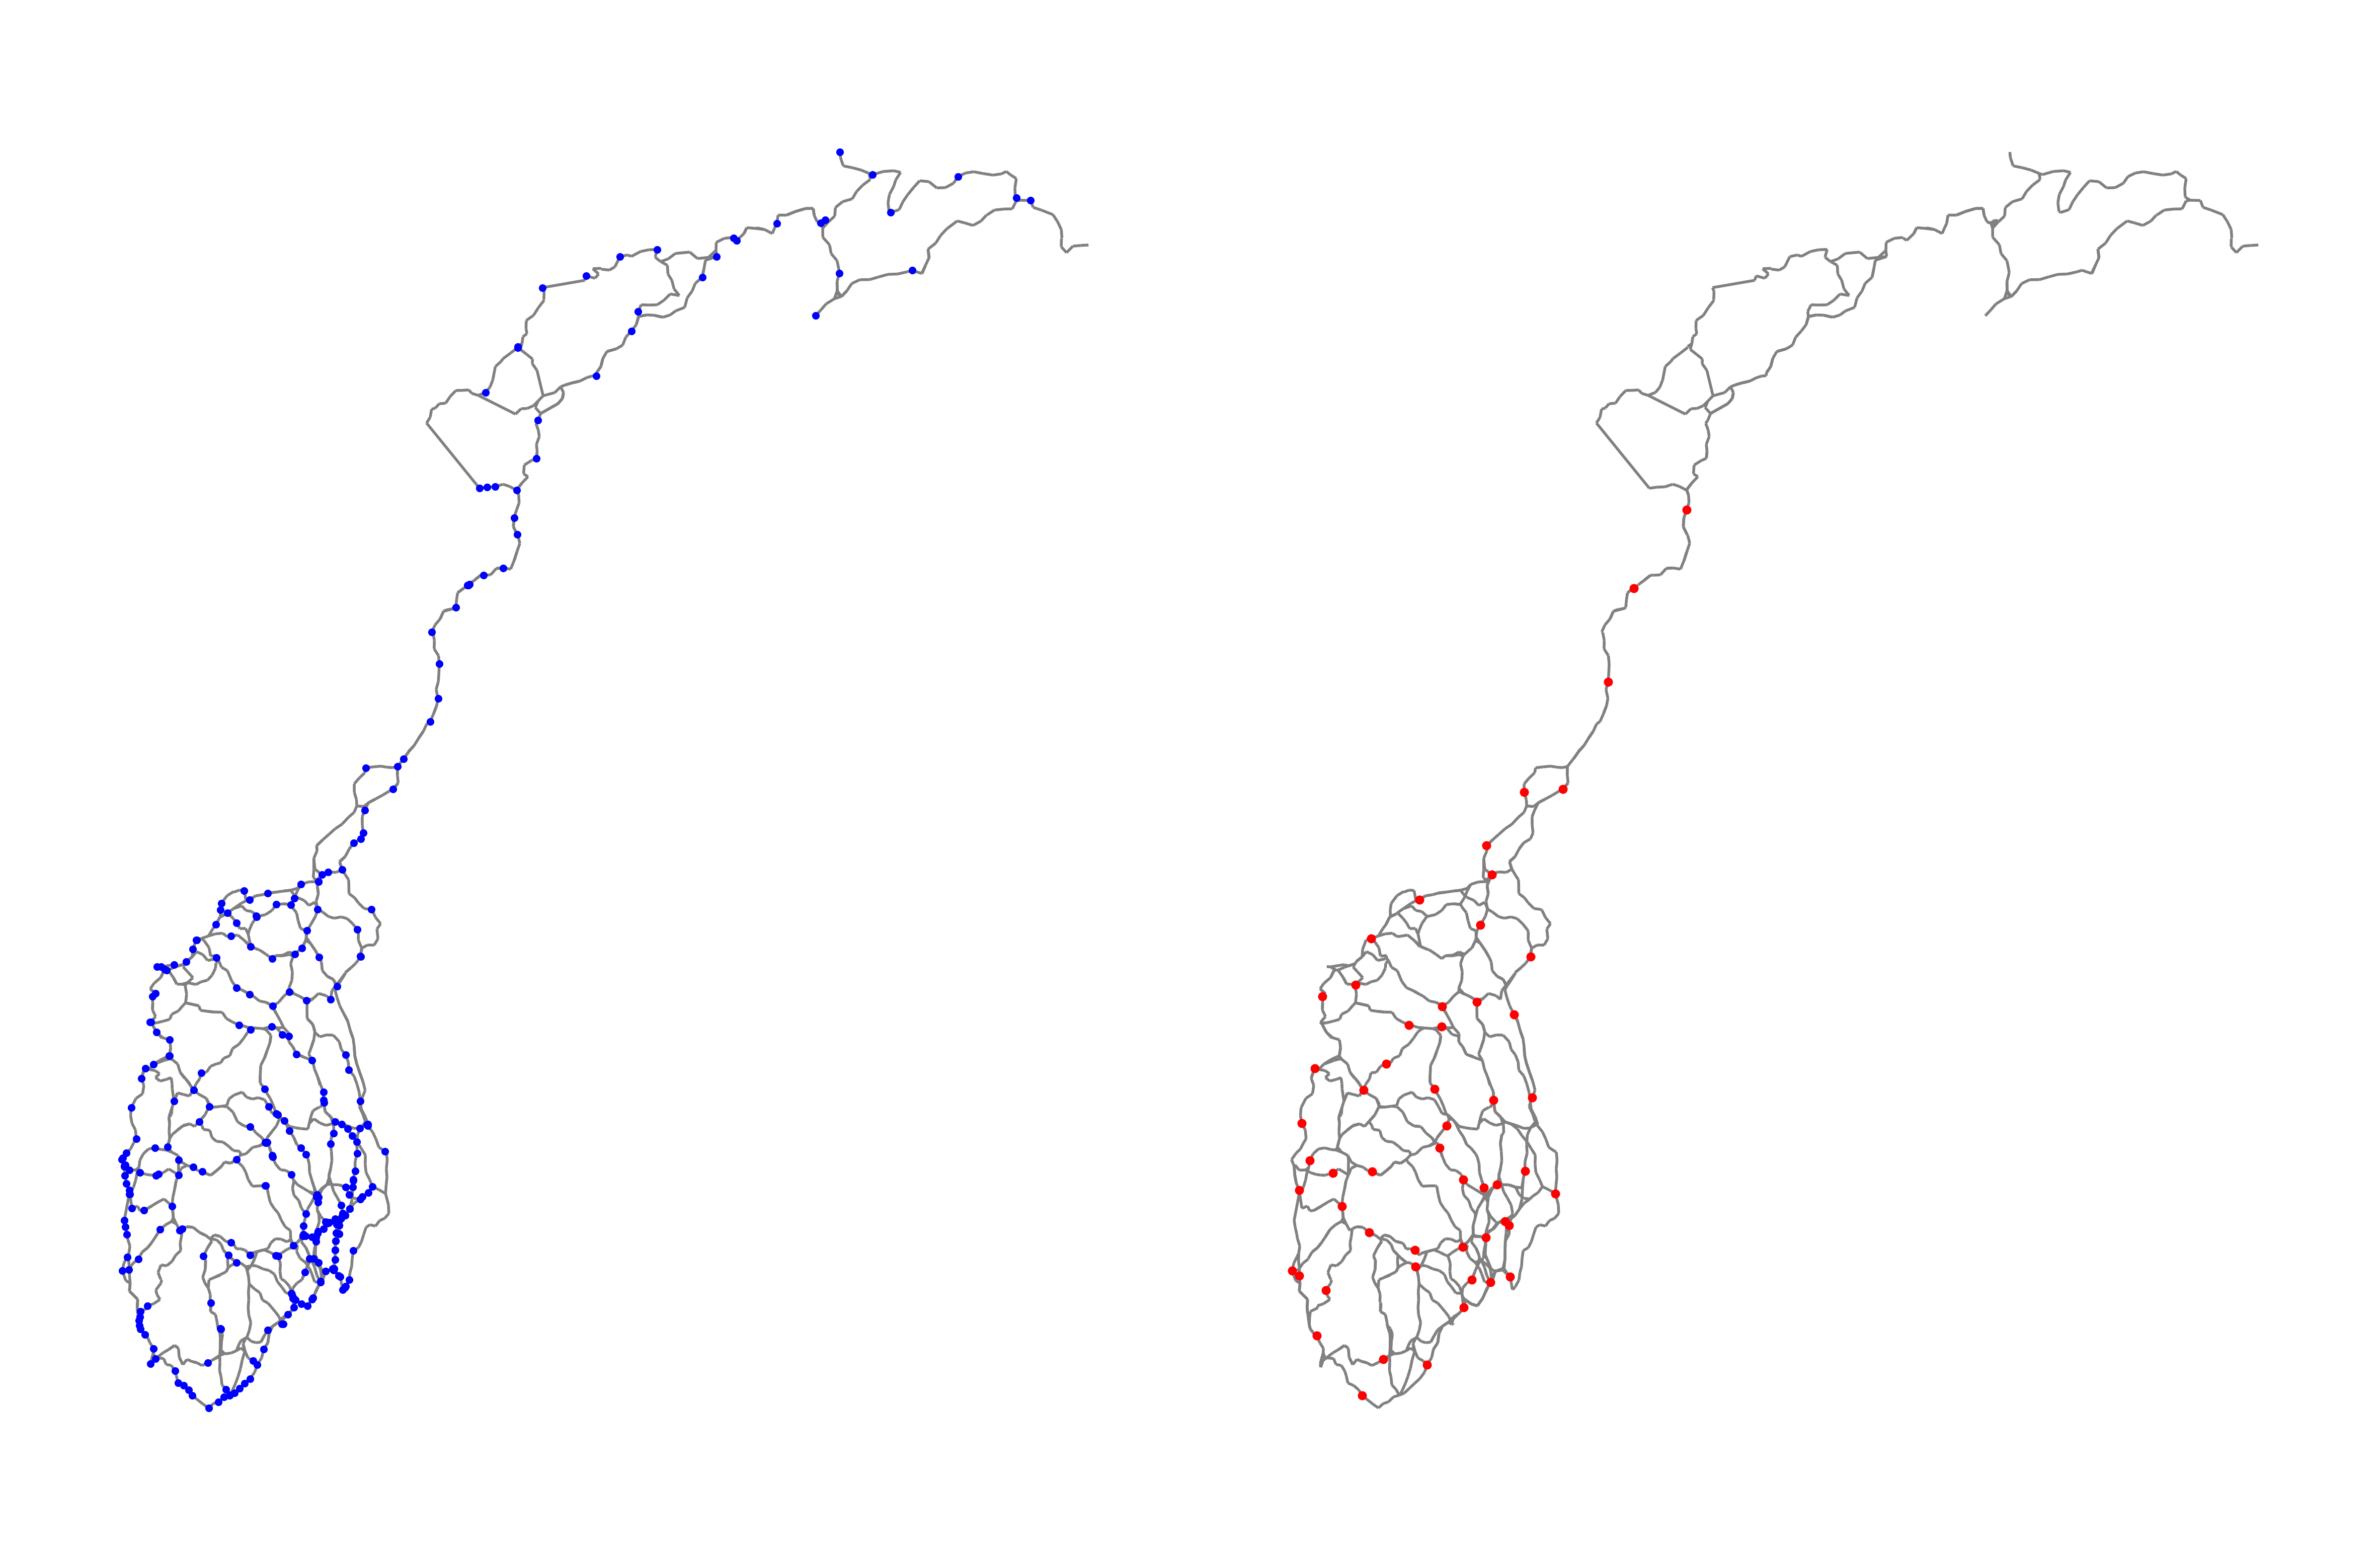

In [56]:
#Plot current vs ga 170 km for current flow covrage
keys = []
vals = []
CurrentCSnodes = []
for i in G.nodes:
    if G.nodes[i]['CS']==1:
        x = G.nodes[i]['x']
        y = G.nodes[i]['y']
        z = (x,y)
        keys.append(i)
        vals.append(z)
        CurrentCSnodes.append(i)
zip_iter=zip(keys,vals)
posCurrent = dict(zip_iter)

keys = []
vals = []
nodelistbest = []
for i in best_pop170:
    if i in G.nodes:
        x = G.nodes[i]['x']
        y = G.nodes[i]['y']
        z = (x,y)
        keys.append(i)
        vals.append(z)
        nodelistbest.append(i)
zip_iter = zip(keys, vals)
posBest = dict(zip_iter)


keys = []
vals = []
for i in G.nodes:
    x = G.nodes[i]['x']
    y = G.nodes[i]['y']
    z = (x,y)
    keys.append(i)
    vals.append(z)
zip_iter = zip(keys, vals)
posAll = dict(zip_iter)

Alledges = []

for i in G.edges:
    Alledges.append(i)


plt.figure(figsize=(15,10), dpi=600)

plt.subplot(1,2,1)
nx.draw_networkx_edges(G, posAll, edgelist=Alledges, edge_color='grey')
nx.draw_networkx_nodes(G, posCurrent, nodelist=CurrentCSnodes, node_size=3, node_color="Blue")
plt.axis("off")
plt.subplot(1,2,2)
nx.draw_networkx_edges(G, posAll, edgelist=Alledges, edge_color='grey')
nx.draw_networkx_nodes(G, posBest, nodelist=nodelistbest, node_size=5, node_color="red")

plt.subplots_adjust(wspace=0,hspace=0)
plt.axis("off")
plt.savefig("Data/Figures/170GAvsCurrent.png", dpi=600, bbox_inches="tight", pad_inches=0)



In [ ]:
#produce solution of GA for p=25,40,70 for all EV ranges
pvals = [25,40,70]
vehranges = [170000,325000.585000]
allflows = []
currentp = []
allruntimes = []
allvranges = []
allpopus = []
for j in vehranges:
    
    for i in range(3):
        p = pvals[i]
        pop_limit = round(math.ceil(1583/p)/2)
        mutation_freq = 0.05
        nr_gen = 25
        k = tuple(G.nodes)
        Totalrange = j

        bestflow, best_popu, runtimeGA = genetic_pop(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict, solution_co=[], indicat=0)
        allflows.append(bestflow)
        currentp.append(p)
        allruntimes.append(runtimeGA)
        allvranges.append(j)
        allpopus.append(best_popu)
d = {'EV Range':allvranges, 'Number of CS':currentp, 'Flow Captured':allflows, 'Runtime':allruntimes, 'facilities':allpopus}
GAresults = pd.DataFrame(d)

In [66]:
#Combine greedy and GA. Note values and repeat for different ranges and p
solution_co=GAresults.iloc[2]['facilities'].copy()
indicat=1
p = len(solution_co)
pop_limit = round(math.ceil(1583/p)/2)
mutation_freq = 0.05
nr_gen = 25
k = tuple(G.nodes)
Totalrange = 170000

value_2, popu_170, runtime170=genetic_pop(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict, solution_co, indicat)

solutionc_co2, greedycapturedflow170, greedyruntime170 = greedysub_mod(k, Totalrange, flows, paths, lengths_dict, G_dict, Threshold, popu_170)


Generation: 1 Flow: 0.9774913570135549 3872.7
Generation: 2 Flow: 0.9777224388069097 3784.3
Generation: 3 Flow: 0.9959941435052172 3517.9
Generation: 4 Flow: 0.9959941435052172 3389.9
Generation: 5 Flow: 0.9960714336799515 2145.8
Generation: 6 Flow: 0.9961798019109172 1574.4
Generation: 7 Flow: 0.9971244448019198 1512.9
Generation: 8 Flow: 0.9971244448019198 1306.5
Generation: 9 Flow: 0.9971244448019198 933.2
Generation: 10 Flow: 0.9971244448019198 596.4
22634.0 sek


In [ ]:
solution_co3=solutionc_co2.copy()
indicat=1
p = len(solution_co3)
pop_limit = round(math.ceil(1583/p)/2)
mutation_freq = 0.05
nr_gen = 25
k = tuple(G.nodes)
Totalrange = 170000

value_2, popu_170, runtime170=geneticv3(k, p, pop_limit, mutation_freq, nr_gen, Totalrange, flows, paths, lengths_dict, G_dict, solution_co, indicat)

In [16]:
#Plot best solution 170km


keys = []
vals = []
nodelistbest = []
for i in popu_170:
    if i in G.nodes:
        x = G.nodes[i]['x']
        y = G.nodes[i]['y']
        z = (x,y)
        keys.append(i)
        vals.append(z)
        nodelistbest.append(i)
zip_iter = zip(keys, vals)
posBest = dict(zip_iter)


keys = []
vals = []
for i in G.nodes:
    x = G.nodes[i]['x']
    y = G.nodes[i]['y']
    z = (x,y)
    keys.append(i)
    vals.append(z)
zip_iter = zip(keys, vals)
posAll = dict(zip_iter)

Alledges = []

for i in G.edges:
    Alledges.append(i)


plt.figure(figsize=(15,10), dpi=600)
nx.draw_networkx_edges(G, posAll, edgelist=Alledges, edge_color='grey')
nx.draw_networkx_nodes(G, posBest, nodelist=nodelistbest, node_size=5, node_color="red")

plt.subplots_adjust(wspace=0,hspace=0)
plt.axis("off")
plt.savefig("Data/Figures/Best170.png", dpi=600, bbox_inches="tight", pad_inches=0)

In [22]:
vranges = [170000, 325000, 585000]
allps = [80, 65, 30]
allflows = [flow170, flow325, flow585]
allruntimes = [runtime170, runtime325, runtime585]
d = {'EV range':vranges, 'p':allps, 'Flow':allflows, 'runtime':allruntimes}
df11 = pd.DataFrame(d)
